# Higgs Challenge Example using Neural Networks
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using neural networks (NN). The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**. More information about the data is available from the links, and in particular at **[Documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**. The general idea is that we want to extract $H\to\tau\tau$ signal from background. In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. The challenge is based on Monte Carlo events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.


Information on [Neutral Networks][1].

[1]: NN_Activation.ipynb

Now let's start trying to apply a NN to the Higgs Challenge data. We will start using Scikit Learn, and then try **[Keras](https://keras.io/)**.

In [16]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')

In [18]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


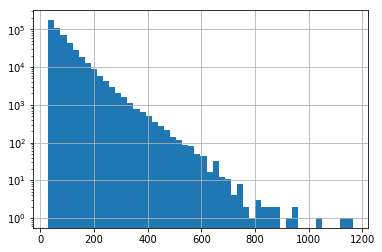

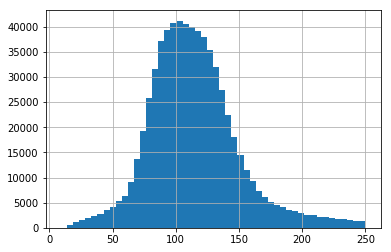

In [19]:
df.PRI_jet_leading_pt[df.PRI_jet_leading_pt>0].hist(bins=50)
plt.yscale('log')

f=plt.figure()
df.DER_mass_MMC[(df.DER_mass_MMC>0)&(df.DER_mass_MMC<250)].hist(bins=50)

There is more information about the variables in the documentation. The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from backround. On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. They themselves generally do not provide much discrimination, but one if the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. *EventId* identifies the event but is not a "feature." The *Weight* is the event weight so that the sum of weights of all signal events should produce the signal yield expected to be observed in 2012, and the sum of weights of all background events should produce the backgroudn yield. Note that the weight varies event to event, because different background and signal processes contribute to the background and signal sets. *Label* indicates if it is a signal or background event. Ignore the *Kaggle* variables--they are only used if you want to reproduce exactly what was used in the Challenge. 

In [20]:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,0,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,0,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,1,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,1,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,0,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,1,t,0.001502


In [21]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,0,t,6.245333


In [22]:
# let's create separate arrays
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [23]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

# Neural networks (MLP) in sklearn

In [24]:
# now let's first look at a NN in sklearn
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(verbose=True)


In [25]:
# and train
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.99924747
Iteration 2, loss = 0.74596920
Iteration 3, loss = 0.70451243
Iteration 4, loss = 0.61863146
Iteration 5, loss = 0.61246565
Iteration 6, loss = 0.58735310
Iteration 7, loss = 0.55872872
Iteration 8, loss = 0.54823607
Iteration 9, loss = 0.53076824
Iteration 10, loss = 0.50875748
Iteration 11, loss = 0.48971593
Iteration 12, loss = 0.48518637
Iteration 13, loss = 0.46911667
Iteration 14, loss = 0.46353245
Iteration 15, loss = 0.46205273
Iteration 16, loss = 0.45421945
Iteration 17, loss = 0.44479577
Iteration 18, loss = 0.43524869
Iteration 19, loss = 0.43659302
Iteration 20, loss = 0.42953868
Iteration 21, loss = 0.42546443
Iteration 22, loss = 0.42183441
Iteration 23, loss = 0.41848275
Iteration 24, loss = 0.41585364
Iteration 25, loss = 0.41241734
Iteration 26, loss = 0.40869482
Iteration 27, loss = 0.40648287
Iteration 28, loss = 0.40533823
Iteration 29, loss = 0.40220722
Iteration 30, loss = 0.40217402
Iteration 31, loss = 0.39989184
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [26]:
mlp.score(X_test, y_test)

0.8257159681355757

We will again use the [approximate median significance][1] from the Kaggle competition to determine how good a solution was. Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the toal yield, which we will do below.

[1]: AMS.ipynb

In [27]:
# load function to compute approximate median significance (AMS)
%pycat ams.py
%run ams.py

<Figure size 432x288 with 0 Axes>

In [28]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob = mlp.predict_proba(X_train)[:, 1]
y_test_prob = mlp.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob,85)
pcut

0.8221556326687097

In [29]:
# add the probability to the original data frame
df['Prob']=mlp.predict_proba(X)[:, 1]


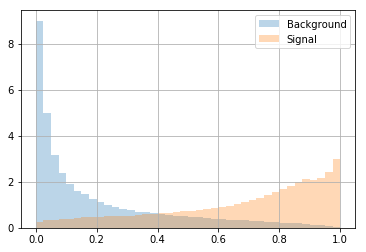

In [30]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)

df[df.Label==0].Prob.hist(label='Background',**kwargs)
df[df.Label==1].Prob.hist(label='Signal',**kwargs)
plt.legend()


In [31]:
# Let's calculate the total weights (yields)
sigall = weight.dot(y)
backall = weight.dot(y == 0)

# The training weights
sigtrain = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# The training weights
sigtest = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [32]:
# Now let's look at event yields that pass our selection
sigtrain_sel = weight_train.dot(np.multiply(y_train, y_train_prob > pcut))
backtrain_sel = weight_train.dot(np.multiply(y_train == 0, y_train_prob > pcut))

sigtest_sel = weight_test.dot(np.multiply(y_test, y_test_prob > pcut))
backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))


In [33]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_corr = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_corr, ", background =",backtrain_sel_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_corr, ", background =",backtest_sel_corr)


('Corrected selected yields in training sample, signal =', 251.9636594989767, ', background =', 7032.958816708725)
('Corrected selected yields in test sample, signal =', 251.50940132139812, ', background =', 7245.1373889984)


In [34]:
print("AMS of training sample", ams(sigtrain_sel_corr,backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr,backtest_sel_corr))

('AMS of training sample', 2.984703267140685)
('AMS of test sample', 2.935963543220404)


How did we do? Worse than the BDT from yesterday.
![Comparison with submissions](data/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

## Rescaling
Neural networks are quite sensitive to feature scaling, so let's try to scale the features.

In [35]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
X_train.columns

Index([u'DER_mass_MMC', u'DER_mass_transverse_met_lep', u'DER_mass_vis',
       u'DER_pt_h', u'DER_deltaeta_jet_jet', u'DER_mass_jet_jet',
       u'DER_prodeta_jet_jet', u'DER_deltar_tau_lep', u'DER_pt_tot',
       u'DER_sum_pt', u'DER_pt_ratio_lep_tau', u'DER_met_phi_centrality',
       u'DER_lep_eta_centrality', u'PRI_tau_pt', u'PRI_tau_eta',
       u'PRI_tau_phi', u'PRI_lep_pt', u'PRI_lep_eta', u'PRI_lep_phi',
       u'PRI_met', u'PRI_met_phi', u'PRI_met_sumet', u'PRI_jet_num',
       u'PRI_jet_leading_pt', u'PRI_jet_leading_eta', u'PRI_jet_leading_phi',
       u'PRI_jet_subleading_pt', u'PRI_jet_subleading_eta',
       u'PRI_jet_subleading_phi', u'PRI_jet_all_pt'],
      dtype='object')

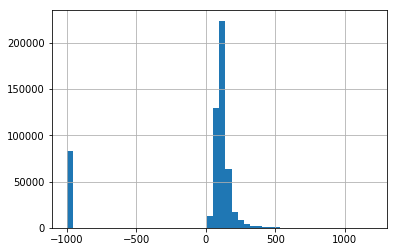

In [37]:
X_train.DER_mass_MMC.hist(bins=50)

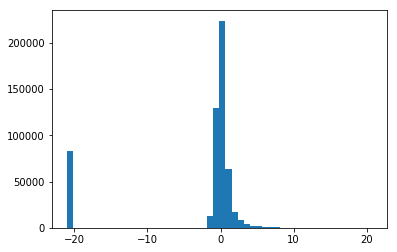

In [38]:
a=plt.hist(X_train_scaled[:,0],bins=50)

In [39]:
# and train a new network
mlp_scaled = MLPClassifier(verbose=True)
mlp_scaled.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.40272580
Iteration 2, loss = 0.37932192
Iteration 3, loss = 0.37356315
Iteration 4, loss = 0.36959943
Iteration 5, loss = 0.36736172
Iteration 6, loss = 0.36573670
Iteration 7, loss = 0.36488144
Iteration 8, loss = 0.36404630
Iteration 9, loss = 0.36331349
Iteration 10, loss = 0.36294233
Iteration 11, loss = 0.36256881
Iteration 12, loss = 0.36226238
Iteration 13, loss = 0.36181800
Iteration 14, loss = 0.36142294
Iteration 15, loss = 0.36129177
Iteration 16, loss = 0.36109845
Iteration 17, loss = 0.36071280
Iteration 18, loss = 0.36070939
Iteration 19, loss = 0.36050698
Iteration 20, loss = 0.36022174
Iteration 21, loss = 0.35998558
Iteration 22, loss = 0.36006652
Iteration 23, loss = 0.35967601
Iteration 24, loss = 0.35975772
Iteration 25, loss = 0.35952509
Iteration 26, loss = 0.35926914
Iteration 27, loss = 0.35922307
Iteration 28, loss = 0.35915409
Iteration 29, loss = 0.35917391
Iteration 30, loss = 0.35898689
Iteration 31, loss = 0.35908542
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [40]:
mlp_scaled.score(X_test_scaled, y_test)

0.8379225165636492

In [41]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_scaled = mlp_scaled.predict_proba(X_train_scaled)[:, 1]
y_test_prob_scaled = mlp_scaled.predict_proba(X_test_scaled)[:, 1]
pcut_scaled = np.percentile(y_train_prob_scaled,85)


In [42]:
# Now let's look at event yields that pass our selection
sigtrain_sel_scaled = weight_train.dot(np.multiply(y_train, y_train_prob_scaled > pcut_scaled))
backtrain_sel_scaled = weight_train.dot(np.multiply(y_train == 0, y_train_prob_scaled > pcut_scaled))

sigtest_sel_scaled = weight_test.dot(np.multiply(y_test, y_test_prob_scaled > pcut_scaled))
backtest_sel_scaled = weight_test.dot(np.multiply(y_test == 0, y_test_prob_scaled > pcut_scaled))


In [43]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_scaled_corr = sigtrain_sel_scaled*sigall/sigtrain
backtrain_sel_scaled_corr = backtrain_sel_scaled*backall/backtrain

sigtest_sel_scaled_corr = sigtest_sel_scaled*sigall/sigtest
backtest_sel_scaled_corr = backtest_sel_scaled*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_scaled_corr, ", background =",backtrain_sel_scaled_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_scaled_corr, ", background =",backtest_sel_scaled_corr)


('Corrected selected yields in training sample, signal =', 240.4131079312425, ', background =', 4578.064274343947)
('Corrected selected yields in test sample, signal =', 239.16114845849899, ', background =', 4971.4413050347985)


In [44]:
print("AMS of training sample", ams(sigtrain_sel_scaled_corr,backtrain_sel_scaled_corr))
print("AMS of test sample", ams(sigtest_sel_scaled_corr,backtest_sel_scaled_corr))

('AMS of training sample', 3.5189663104026203)
('AMS of test sample', 3.361958116653685)


We improved somewhat.

# Neutral networks with Keras
SciKit Learn has simple NNs, but if you want to do deep NNs, or train on GPUs, you probalby want to use something like Keras instead. Let's try to create a simple NN using Keras.

In [45]:
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


In [46]:
# create the model
from keras import regularizers

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(30,), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1, activation='sigmoid'))


In [47]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
class_weight = {0: y_train.shape[0]/backtrain, 1:y_train.shape[0]/sigtrain}
class_weight

{0: 1.9909186536998729, 1: 1182.31507085564}

In [49]:
#model.fit(X_train_scaled, y_train, epochs=5, batch_size=128, sample_weight=weight_train)
model.fit(X_train_scaled, y_train, epochs=5, batch_size=64)


Epoch 1/5
548219/548219 [==============================] - 12s 21us/step - loss: 0.3998 - acc: 0.8235
Epoch 2/5
548219/548219 [==============================] - 10s 18us/step - loss: 0.3828 - acc: 0.8320
Epoch 3/5
548219/548219 [==============================] - 10s 19us/step - loss: 0.3780 - acc: 0.8333
Epoch 4/5
548219/548219 [==============================] - 10s 18us/step - loss: 0.3757 - acc: 0.8343
Epoch 5/5
548219/548219 [==============================] - 10s 19us/step - loss: 0.3743 - acc: 0.8346


In [50]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_keras = model.predict(X_train_scaled)[:, 0]
y_test_prob_keras = model.predict(X_test_scaled)[:, 0]
pcut_keras = np.percentile(y_train_prob_keras,85)


In [51]:
y_test_prob_keras

array([0.78310543, 0.08843698, 0.01610034, ..., 0.19183278, 0.09180357,
       0.01434869], dtype=float32)

In [52]:
# Now let's look at event yields that pass our selection
sigtrain_sel_keras = weight_train.dot(np.multiply(y_train, y_train_prob_keras > pcut_keras))
backtrain_sel_keras = weight_train.dot(np.multiply(y_train == 0, y_train_prob_keras > pcut_keras))

sigtest_sel_keras = weight_test.dot(np.multiply(y_test, y_test_prob_keras > pcut_keras))
backtest_sel_keras = weight_test.dot(np.multiply(y_test == 0, y_test_prob_keras > pcut_keras))


In [53]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_keras_corr = sigtrain_sel_keras*sigall/sigtrain
backtrain_sel_keras_corr = backtrain_sel_keras*backall/backtrain

sigtest_sel_keras_corr = sigtest_sel_keras*sigall/sigtest
backtest_sel_keras_corr = backtest_sel_keras*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_keras_corr, ", background =",backtrain_sel_keras_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_keras_corr, ", background =",backtest_sel_keras_corr)


('Corrected selected yields in training sample, signal =', 242.18985998167906, ', background =', 5027.710490980152)
('Corrected selected yields in test sample, signal =', 240.2657955998294, ', background =', 5298.490487588569)


In [54]:
print("AMS of training sample", ams(sigtrain_sel_keras_corr,backtrain_sel_keras_corr))
print("AMS of test sample", ams(sigtest_sel_keras_corr,backtest_sel_keras_corr))

('AMS of training sample', 3.385431060374011)
('AMS of test sample', 3.273246139011499)


We only made a single layer NN in Keras. However, you can easily change the structure of the network. As an assignment, try adding an extra hidden layer and changing the number of neurons.

There are a few things we can easily vary: number of hidden layers, the activation function, the regularization ($\alpha$). Let's go back to MLPClassifer (scaled) and play with some of them.

In [55]:
mlp_play = MLPClassifier(activation='relu', hidden_layer_sizes=(100,100), alpha=0.01, verbose=True)
mlp_play.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.39096249
Iteration 2, loss = 0.37133968
Iteration 3, loss = 0.36800982
Iteration 4, loss = 0.36624022
Iteration 5, loss = 0.36514912
Iteration 6, loss = 0.36445364
Iteration 7, loss = 0.36370807
Iteration 8, loss = 0.36318460
Iteration 9, loss = 0.36265512
Iteration 10, loss = 0.36232185
Iteration 11, loss = 0.36196902
Iteration 12, loss = 0.36160899
Iteration 13, loss = 0.36140230
Iteration 14, loss = 0.36134344
Iteration 15, loss = 0.36112840
Iteration 16, loss = 0.36090546
Iteration 17, loss = 0.36067543
Iteration 18, loss = 0.36049588
Iteration 19, loss = 0.36048507
Iteration 20, loss = 0.36038929
Iteration 21, loss = 0.36016239
Iteration 22, loss = 0.36018317
Iteration 23, loss = 0.36006408
Iteration 24, loss = 0.35998173
Iteration 25, loss = 0.36003014
Iteration 26, loss = 0.35982232
Iteration 27, loss = 0.35983919
Iteration 28, loss = 0.35978657
Iteration 29, loss = 0.35958220
Iteration 30, loss = 0.35959033
Iteration 31, loss = 0.35961342
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [56]:
mlp_play.score(X_test_scaled, y_test)

0.8371559038438036

In [57]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_play = mlp_play.predict_proba(X_train_scaled)[:, 1]
y_test_prob_play = mlp_play.predict_proba(X_test_scaled)[:, 1]
pcut_play = np.percentile(y_train_prob_scaled,85)


In [58]:
# Now let's look at event yields that pass our selection
sigtrain_sel_play = weight_train.dot(np.multiply(y_train, y_train_prob_play > pcut_play))
backtrain_sel_play = weight_train.dot(np.multiply(y_train == 0, y_train_prob_play > pcut_play))

sigtest_sel_play = weight_test.dot(np.multiply(y_test, y_test_prob_play > pcut_play))
backtest_sel_play = weight_test.dot(np.multiply(y_test == 0, y_test_prob_play > pcut_play))


In [59]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_play_corr = sigtrain_sel_play*sigall/sigtrain
backtrain_sel_play_corr = backtrain_sel_play*backall/backtrain

sigtest_sel_play_corr = sigtest_sel_play*sigall/sigtest
backtest_sel_play_corr = backtest_sel_play*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_play_corr, ", background =",backtrain_sel_play_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_play_corr, ", background =",backtest_sel_play_corr)


('Corrected selected yields in training sample, signal =', 180.55578055288962, ', background =', 2467.000016358353)
('Corrected selected yields in test sample, signal =', 180.13992838589002, ', background =', 2741.9766162978685)


In [60]:
print("AMS of training sample", ams(sigtrain_sel_play_corr,backtrain_sel_play_corr))
print("AMS of test sample", ams(sigtest_sel_play_corr,backtest_sel_play_corr))

('AMS of training sample', 3.585055243644966)
('AMS of test sample', 3.3974231077123065)


# Your tasks
Problems (can do with either MLPClassifier or Keras):
1. Vary the structure of the tree (number of hidden layers, number of neurons)
1. Vary the activation. (In Keras can do it per layer, in MLPClassifier only for all)
1. Vary the regularization. May have to do this as the structure changes.
1. Try using derivied variables only or primary variables only.
1. Missing data is represented by -999 before scaling. Is there a better value to use in the training?
1. Try using the event weights to better match the background and signal shapes in the training. Note, though, that you should still treat background and signal separately; don't scale the signal down by the weight.